In [393]:
import os
import json
import pandas as pd
import numpy as np
import requests
import re

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

from collections import defaultdict
from sklearn.neighbors import BallTree

In [365]:
paths = [path for path in os.listdir() if path.endswith(".pickle") and re.match("[0-9]",path)]

In [366]:
df = pd.DataFrame([pd.read_pickle(path) for path in paths])

In [367]:
# Charging stations
len(df)

1896

Due to the noise of the data, some of the data points are in Germany, Sweden or others. Since we are focusing on Denmark we want to filter these out

In [374]:
df = df[-df.country_code.isin(["DE", "SE"])]

This cleared out most of them, there are still some stragglers however so we use the charging stations' adresses which are formatted nicely and therefore we can use them to identify things we do not want to include, i.e. the rest that are in charging stations that are in Germany, Sweden or El Salvador

In [375]:
print(df["address"].apply(lambda x: x.split(",")[-1].strip() if type(x) == str else "fail").unique()[:10], "...")

['Denmark' 'Danmark' 'DK' '7330 Brande' '2900 Hellerup' 'Vesterhavsvej'
 '6854' '5700 Svendborg' '7430 Ikast'
 'Vermlandsgade 41 2300 København S Danmark'] ...


In [380]:
# How many of the rows are foreign charging stations
print(len(df[df.address.str.contains("(Deutschland|DE|Sweden|Sverige|El Salvador|Germany)")]))

13


In [381]:
df = df[-df.address.str.contains("(Deutschland|DE|Sweden|Sverige)")]

In [382]:
# This has jumbled the index, so now there are gaps, we can use the id as new index
df = df.set_index("id")

In [385]:
df.head()

,latitude,longitude,address,created_at,municipality,city,zip_code,plugs,cost_description,description,country_code
id,,,,,,,,,,,
96548,55.494803,9.721409,"Teglgårdsvej 73, 5500 Middelfart, Denmark",2016-10-01T10:37:25Z,Middelfart Municipality,Middelfart,5500,11,Free,Free for hotel guests: http://www.sinatur.dk/m...,DK
337709,55.653682,12.614406,"Elbagade 28, 2300 København, Danmark",2021-09-09T20:26:12Z,None,København,2300,11,Clever,,DK
91943,56.292127,10.444662,"Præstekravevej 46, 8410 Rønde, Denmark",2016-07-25T14:01:47Z,Syddjurs Municipality,Rønde,8410,11,,2x Red CEE Free for hotel guests\nTesla Destin...,DK
70961,55.215571,9.372034,"Sønderjyske Motorvej 684, 6500 Vojens, Denmark",2015-09-12T00:45:42Z,Haderslev Municipality,Vojens,6500,11,clever.dk,"Clever 50 kW DC, 43 kW aC",DK
81790,55.694021,12.544642,"Husumgade 32, 2200 København N, Denmark",2016-03-02T11:14:06Z,København,København,2200,11,,Charging Station Virta,DK


In [386]:
# We don't want to query the API more than we have to, so we take the 7 nearest neighbors of each charging stations to minimize the search space.
distances, knn = BallTree(df.loc[:,["latitude","longitude"]]).query(df.loc[:,["latitude","longitude"]], 8)

In [357]:
with open("API_KEY", "r") as file:
    auth = file.readline().strip()

In [30]:
#test = requests.get(f"https://router.hereapi.com/v8/routes?apiKey={auth}&transportMode=car&origin=52.5308,13.3847&destination=52.5323,13.3789&return=summary")

In [16]:
if "meters.pickle" in os.listdir() and "backup.pickle" in os.listdir():
    meters = pd.read_pickle("meters.pickle")
    backup = pd.read_pickle("backup.pickle")
else:
    meters = defaultdict() # placeholder list to put to df
    backup = defaultdict(list) # backup of all the requests
    for i, neighbors_of_point in enumerate(knn):
        spot = df.iloc[neighbors_of_point[0]].name
        orig_lat = df.iloc[neighbors_of_point[0]].latitude
        orig_lon = df.iloc[neighbors_of_point[0]].longitude
        meters[spot] = 1000000000
        for neighbor in neighbors_of_point[1:]:
            dest_lat = df.iloc[neighbor,:].latitude
            dest_lon = df.iloc[neighbor,:].longitude
            query = requests.get(f"https://router.hereapi.com/v8/routes?apiKey={auth}&transportMode=car&origin={orig_lat},{orig_lon}&destination={dest_lat},{dest_lon}&return=travelSummary")
            response = query.json()
            backup[spot].append(response)
            meter = response["routes"][0]["sections"][0]["travelSummary"]["length"]
            if meters[spot] > meter:
                meters[spot] = meter
        if len(backup) % 200 == 0:
            print(f"{len(backup)} responses done...")

200 responses done...
400 responses done...
600 responses done...
800 responses done...
1000 responses done...
1200 responses done...
1400 responses done...
1600 responses done...
1800 responses done...


In [20]:
# For some indices here wasnt able to find anything
df.loc[df.index.isin([idx for idx in df.index if idx not in meters])].index

Int64Index([344161, 309578, 249382, 295971, 35794], dtype='int64', name='id')

In [25]:
for NA in [idx for idx in df.index if idx not in meters]:
    meters[NA] = None

In [27]:
new_one["closest_in_meters"] = meters

In [429]:
new_one["closest_in_meters"] = new_one["closest_in_meters"].astype(float)

In [229]:
#hmm
rev_coord = lambda x: requests.get(
    f"https://revgeocode.search.hereapi.com/v1/revgeocode?at={x.latitude},{x.longitude}&apiKey={auth}"
).json()
reversed_coord = new_one.loc[:,["latitude", "longitude"]].apply(rev_coord, axis = 1)

In [ ]:
# county list to sanity check
municipalities = ["København","Aarhus","Aalborg","Odense","Vejle","Esbjerg","Frederiksberg","Randers","Viborg","Silkeborg","Kolding","Horsens","Herning","Roskilde","Næstved","Slagelse","Gentofte","Sønderborg","Holbæk","Gladsaxe","Hjørring","Skanderborg","Helsingør","Køge","Guldborgsund","Frederikshavn","Holstebro","Svendborg","Aabenraa","Rudersdal","Lyngby-Taarbæk","Ringkøbing-Skjern","Haderslev","Hvidovre","Høje Taastrup","Faaborg-Midtfyn","Hillerød","Fredericia","Greve","Varde","Ballerup","Kalundborg","Favrskov","Hedensted","Frederikssund","Skive","Vordingborg","Egedal","Syddjurs","Thisted","Vejen","Tårnby","Mariagerfjord","Ikast-Brande","Rødovre","Furesø","Fredensborg","Gribskov","Assens","Lolland","Bornholm", "Middelfart","Jammerbugt","Tønder","Norddjurs","Faxe","Vesthimmerlands","Brønderslev","Brøndby","Ringsted","Odsherred","Nyborg","Halsnæs","Rebild","Sorø","Nordfyns","Herlev","Lejre","Albertslund","Billund","Allerød","Hørsholm","Kerteminde","Solrød","Odder","Ishøj","Stevns","Glostrup","Struer","Morsø","Lemvig","Vallensbæk","Dragør","Langeland","Ærø","Samsø","Fanø","Læsø"]

In [255]:
def get_counties(reversed_coord):
    county = reversed_coord["items"][0]["address"]["county"]
    if county == "Lyngby Tårbæk":
        county = "Lyngby-Taarbæk"
    if county in municipalities:
        return county
    else:
        print(county)
        raise ValueError("Oops")

In [261]:
new_one["municipality"] = reversed_coord.apply(get_counties)

<ipython-input-261-d357cb0605b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_one["municipality"] = reversed_coord.apply(get_counties)


In [280]:
# Unable to find anything on the here api for these 5 indices
new_one = new_one[~new_one.index.isin([62736, 321501, 88915, 125243, 321570])]

In [281]:
new_one["year"] = pd.to_datetime(new_one.created_at).dt.year

<ipython-input-281-4447859d3bc6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_one["year"] = pd.to_datetime(new_one.created_at).dt.year


In [334]:
# Some of the addresses from Plugshare were badly defined, here.api has more precise addresses, we augment the data here
for key, x in new_one.address.items():
    if len(x.split(",")) < 2:
        new_one.loc[key, "address"] = reversed_coord[key]["items"][0]["address"]["label"]

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [421]:
columns = list(new_one)
columns = columns[:3] + columns[-1:] + columns[3:-1]
new_one = new_one[columns]

In [422]:
new_one.to_pickle("standers.pickle")

## Visualization

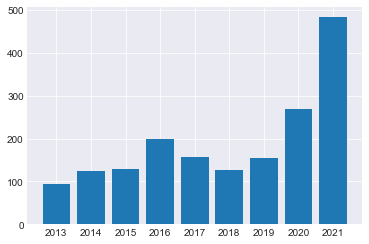

In [417]:
by_year = new_one.groupby("year").size()
plt.bar(by_year.keys(), by_year.values)
plt.xticks(ticks=by_year.keys(), labels=by_year.keys())
plt.show()

<ipython-input-462-ac961bb76830>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


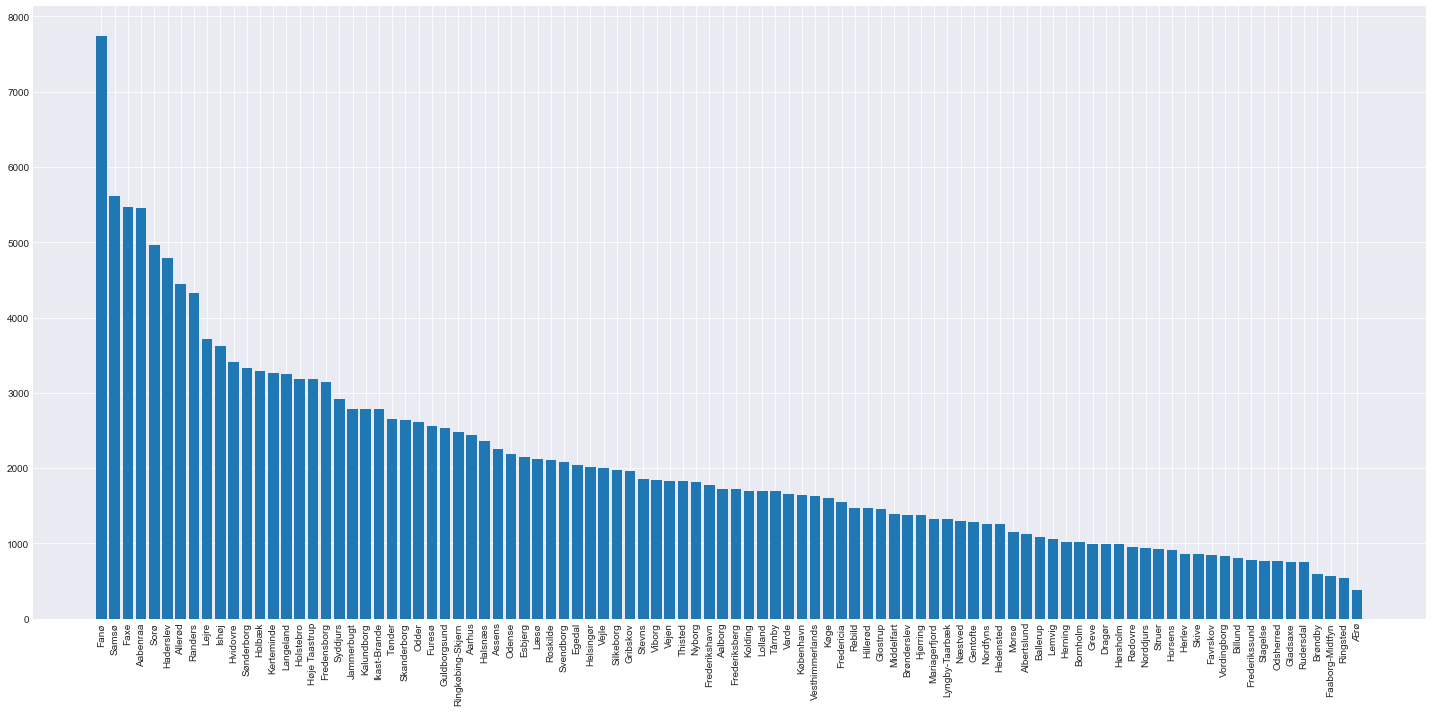

In [462]:
avg_closest = new_one.groupby("municipality").mean()["closest_in_meters"].sort_values(ascending=False)

fig, ax = plt.subplots(figsize = (20,10))
ax.bar(avg_closest.keys(), avg_closest.values)
ax.set_xticks(ticks=range(len(avg_closest.keys())))
ax.set_xticklabels(labels=avg_closest.keys(), rotation=90)
plt.tight_layout()
fig.show()

## Verification

In [395]:
# Geo measurement function which can be used as a sanity check
def measure(lat_lon_1, lat_lon_2): 
    lat1, lon1 = lat_lon_1
    lat2, lon2 = lat_lon_2
    R = 6378.137
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d * 1000

In [394]:
# to be used something like this
f"{df.iloc[0].address} is {measure(df.iloc[0].values[:2], df.iloc[1378].values[:2]):.2f} meters from {df.iloc[1378].address} - coordinately"

'Teglgårdsvej 73, 5500 Middelfart, Denmark is 179289.89 meters from Ægirsgade 65A, 2200 københavn - coordinately'